In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp '/content/gdrive/MyDrive/ergasia_tn/1.zip' . 
!unzip -q 1.zip
!rm 1.zip

In [31]:
#Λίστα data για την αποθήκευση εικόνων
#εχουμε 43 κατηγορίες πινακίδων που ανάλογα με την φωτογραφία θα αποθηκεύονται στην λίστα labels 
#στον πίνακα data θα αποθηκεύονται οι εικόνες τροποποιημένες σε array και ορίζουμε το rootpath και training paths kai test paths
data = []
labels = []
classes = 43
path='/content/'
train_path='/content/Train'
test_path='/content/Test'

In [32]:
#κανουμε import τις βιβλιοθήκες
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import tensorflow as tf

#οι φωτογραφίες μας στο training set είναι σε 43 φακέλους-κατηγορίες , στο πρώτο for πάμε στον κάθε φάκελο ξεχωρίστα και στην δεύτερη for κάνουμε προσπέλαση κάθε αρχείο στον φάκελο
#αποθηκεύουμε κάθε εικόνα σε μια τοπική μεταβλητή , την μετατρέπουμε σε 30Χ30 pixel , έγχρωμη και στην συνέχεια την μετατρέπουμε σε πίνακα με την image_to_array.
#επεκτήνουμε τις λίστες label και data

for i in range(43):
  cat = os.path.join(train_path, str(i))
  for j in os.listdir(cat):
    img_path=os.path.join(cat, j)
    image = tf.keras.preprocessing.image.load_img(img_path,target_size=(30,30),color_mode='rgb')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    data.append(input_arr)
    labels.append(i)            

In [33]:
#μετατρέπουμε τις λίστες σε arrays
import numpy as np

data = np.array(data)
labels = np.array(labels)

In [34]:
#οι εικόνες στο training set είναι 39209 με μέγεθος 30Χ30 και 3 κανάλια rgb 
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [35]:
#χωρίζουμε το training set σε 80training και 20% val
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=365)

In [36]:
#διαιρούμε τις τιμές τους με το 255 για να έχουμε τις τιμές στο [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [37]:
print(X_train.shape)
print(X_test.shape)

(31367, 30, 30, 3)
(7842, 30, 30, 3)


In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [39]:
#ελέγχουμε αν έχει γίνει σωστά η διαδικασία της κατηγοριοποίσης σε μια εικόνα και αν έχουμε λάβει όλες τις κατηγορίες
print(y_train[10])
print(np.unique(y_train))

2
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [40]:
#μετατρέπουμε τις ετικέτες σε one hot διανύσματα 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
#έχουμε κάνει για αρχή ένα πολύ απλό μοντέλο
#με 2 συνελλικτικά επίπεδα και 16 και 32 φίλτρα αντίστοιχα και 2 προς 1 maxpooling layers
# στο τέλος χρησιμοποιούμε την flatten για να μετατρέψουμε την έξοδο το συνελλικτικού σε διάνυσμα και χρησιμοποιούμε την softmax για την κατηγοριοποίηση που ουσιαστικά είναι μια logistic για πάνω από 2 κατηγορίες
from tensorflow import keras
import tensorflow 
from tensorflow.keras import layers

callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
models1=[]
for i in range(5):
    model = keras.Sequential()
    model.add(layers.Input(shape=X_train[0].shape))
    model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(43, activation='softmax'))
    model.summary()
    models1.append(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                67467     
Total params: 72,555
Trainable params: 72,555
Non-trainable params: 0
____________________________________________________

In [ ]:
#εκπαιδεύουμε το μοντέλο με 32 batch_size και 150 εποχές ,χρησιμοποιούμε σαν μετρική το accuracy και το test το βάζουμε για validation


l=[0.01,0.005,0.001,0.0005,0.0001]
hs=[]

for i in range (5):
  batch_size = 32
  epochs = 150
  adam=tf.keras.optimizers.Adam(learning_rate=l[i])
  models1[i].compile(loss="categorical_crossentropy", optimizer=adam,metrics=["accuracy"])
  h=models1[i].fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_test, y_test), callbacks=[callback])
  hs.append(h)

Epoch 1/150
981/981 [==============================] - 35s 4ms/step - loss: 3.5035 - accuracy: 0.0560 - val_loss: 3.4947 - val_accuracy: 0.0481
Epoch 2/150
981/981 [==============================] - 4s 4ms/step - loss: 2.3718 - accuracy: 0.3550 - val_loss: 1.1015 - val_accuracy: 0.6769
Epoch 3/150
981/981 [==============================] - 4s 4ms/step - loss: 0.9420 - accuracy: 0.7280 - val_loss: 0.9029 - val_accuracy: 0.7306
Epoch 4/150
981/981 [==============================] - 4s 4ms/step - loss: 0.7894 - accuracy: 0.7677 - val_loss: 0.8387 - val_accuracy: 0.7609
Epoch 5/150
981/981 [==============================] - 4s 4ms/step - loss: 0.7444 - accuracy: 0.7814 - val_loss: 0.8156 - val_accuracy: 0.7705
Epoch 6/150
981/981 [==============================] - 4s 4ms/step - loss: 0.7089 - accuracy: 0.7911 - val_loss: 0.7743 - val_accuracy: 0.7767
Epoch 7/150
981/981 [==============================] - 4s 4ms/step - loss: 0.6846 - accuracy: 0.7975 - val_loss: 0.8466 - val_accuracy: 0.755

Σταμάτησε μετά από 50 εποχές.


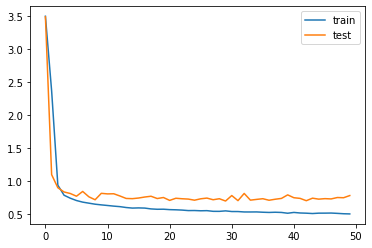

Σταμάτησε μετά από 24 εποχές.


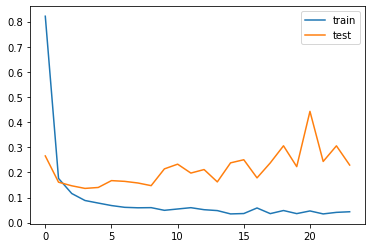

Σταμάτησε μετά από 52 εποχές.


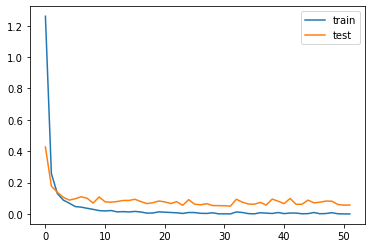

Σταμάτησε μετά από 67 εποχές.


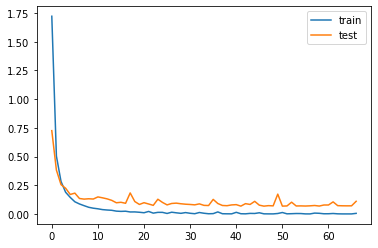

Σταμάτησε μετά από 80 εποχές.


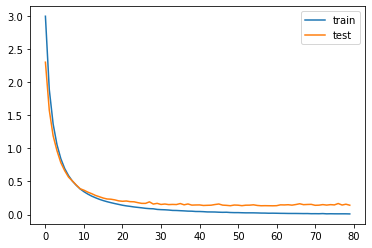

In [ ]:
from matplotlib import pyplot
for i in hs:
  print('Σταμάτησε μετά από '+ str(len(i.history['loss']))+' εποχές.')
  pyplot.plot(i.history['loss'], label='train')
  pyplot.plot(i.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

In [ ]:
from tensorflow import keras
import tensorflow 
from tensorflow.keras import layers

#με 4 συνελλικτικά επίπεδα με 16,32,64,128 φίλτρα αντίστοιχα και 2 προς 1 maxpooling layers
# στο τέλος χρησιμοποιούμε την flatten για να μετατρέψουμε την έξοδο το συνελλικτικού σε διάνυσμα και χρησιμοποιούμε την softmax για την κατηγοριοποίηση που ουσιαστικά είναι μια logistic για πάνω από 2 κατηγορίες
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
models2=[]
for i in range(5):
  model = keras.Sequential()
  model.add(layers.Input(shape=X_train[0].shape))
  model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(43, activation='softmax'))
  model.summary()
  models2.append(model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 3, 128)        

In [ ]:
#εκπαιδεύουμε το μοντέλο με 32 batch_size και 12 εποχές ,χρησιμοποιούμε σαν μετρική το accuracy και το test το βάζουμε για validation
batch_size = 32
epochs = 150

#εκπαιδεύουμε το μοντέλο με 32 batch_size και 12 εποχές ,χρησιμοποιούμε σαν μετρική το accuracy και το test το βάζουμε για validation
l=[0.01,0.005,0.001,0.0005,0.0001]
hs2=[]
for i in range (5):
  batch_size = 32
  epochs = 150
  adam=tf.keras.optimizers.Adam(learning_rate=l[i])
  models2[i].compile(loss="categorical_crossentropy", optimizer=adam,metrics=["accuracy"])
  h=models2[i].fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_test, y_test), callbacks=[callback])
  hs2.append(h)

Epoch 1/150
981/981 [==============================] - 5s 5ms/step - loss: 3.5026 - accuracy: 0.0534 - val_loss: 3.5003 - val_accuracy: 0.0621
Epoch 2/150
981/981 [==============================] - 4s 5ms/step - loss: 3.4932 - accuracy: 0.0545 - val_loss: 3.4932 - val_accuracy: 0.0578
Epoch 3/150
981/981 [==============================] - 4s 4ms/step - loss: 3.4913 - accuracy: 0.0538 - val_loss: 3.4917 - val_accuracy: 0.0559
Epoch 4/150
981/981 [==============================] - 4s 4ms/step - loss: 3.4895 - accuracy: 0.0548 - val_loss: 3.4919 - val_accuracy: 0.0565
Epoch 5/150
981/981 [==============================] - 4s 4ms/step - loss: 3.4887 - accuracy: 0.0551 - val_loss: 3.4898 - val_accuracy: 0.0578
Epoch 6/150
981/981 [==============================] - 4s 4ms/step - loss: 3.4879 - accuracy: 0.0568 - val_loss: 3.4893 - val_accuracy: 0.0565
Epoch 7/150
981/981 [==============================] - 4s 4ms/step - loss: 3.4881 - accuracy: 0.0541 - val_loss: 3.4895 - val_accuracy: 0.0621

Σταμάτησε μετά από 50 εποχές.


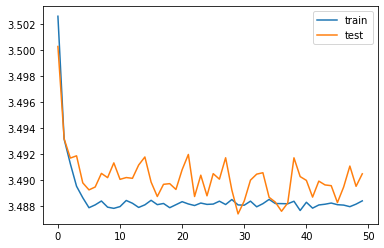

Σταμάτησε μετά από 50 εποχές.


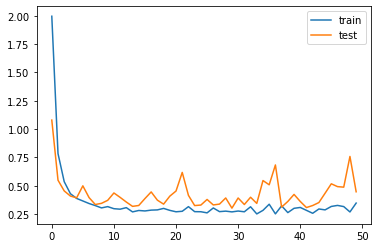

Σταμάτησε μετά από 45 εποχές.


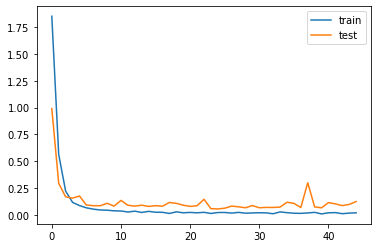

Σταμάτησε μετά από 86 εποχές.


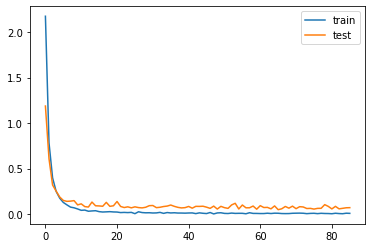

Σταμάτησε μετά από 120 εποχές.


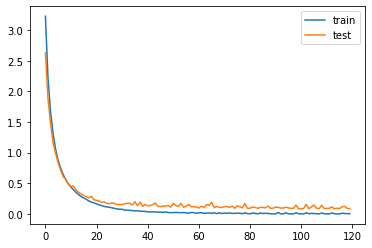

In [ ]:
from matplotlib import pyplot

for i in hs2:
  print('Σταμάτησε μετά από '+ str(len(i.history['loss']))+' εποχές.')
  pyplot.plot(i.history['loss'], label='train')
  pyplot.plot(i.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

In [ ]:
from tensorflow import keras
import tensorflow 
from tensorflow.keras import layers

callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#με 10 συνελλικτικά επίπεδα ανα 2χ2 2χ3, με 16,32,64,128 φίλτρα αντίστοιχα, και 2 προς 1 maxpooling layers
# στο τέλος χρησιμοποιούμε την flatten για να μετατρέψουμε την έξοδο το συνελλικτικού σε διάνυσμα και χρησιμοποιούμε την softmax για την κατηγοριοποίηση που ουσιαστικά είναι μια logistic για πάνω από 2 κατηγορίες
models3=[]
for i in range(5):
  model = keras.Sequential()
  model.add(layers.Input(shape=X_train[0].shape))
  model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(43, activation='softmax'))
  model.summary()
  models3.append(model)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 30, 16)        2320      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 32)        4640      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 64)        

In [ ]:
#εκπαιδεύουμε το μοντέλο με 32 batch_size και 12 εποχές ,χρησιμοποιούμε σαν μετρική το accuracy και το test το βάζουμε για validation
batch_size = 32
epochs = 150

#εκπαιδεύουμε το μοντέλο με 32 batch_size και 12 εποχές ,χρησιμοποιούμε σαν μετρική το accuracy και το test το βάζουμε για validation
l=[0.01,0.005,0.001,0.0005,0.0001]
hs3=[]
for i in range (5):
  batch_size = 32
  epochs = 150
  adam=tf.keras.optimizers.Adam(learning_rate=l[i])
  models3[i].compile(loss="categorical_crossentropy", optimizer=adam,metrics=["accuracy"])
  h=models3[i].fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_test, y_test), callbacks=[callback])
  hs3.append(h)

Epoch 1/150
981/981 [==============================] - 8s 7ms/step - loss: 3.5023 - accuracy: 0.0538 - val_loss: 3.4949 - val_accuracy: 0.0509
Epoch 2/150
981/981 [==============================] - 6s 6ms/step - loss: 3.4932 - accuracy: 0.0557 - val_loss: 3.4969 - val_accuracy: 0.0578
Epoch 3/150
981/981 [==============================] - 7s 7ms/step - loss: 3.4915 - accuracy: 0.0545 - val_loss: 3.4921 - val_accuracy: 0.0578
Epoch 4/150
981/981 [==============================] - 6s 6ms/step - loss: 3.4896 - accuracy: 0.0557 - val_loss: 3.4894 - val_accuracy: 0.0559
Epoch 5/150
981/981 [==============================] - 6s 6ms/step - loss: 3.4886 - accuracy: 0.0557 - val_loss: 3.4915 - val_accuracy: 0.0559
Epoch 6/150
981/981 [==============================] - 6s 6ms/step - loss: 3.4882 - accuracy: 0.0566 - val_loss: 3.4896 - val_accuracy: 0.0578
Epoch 7/150
981/981 [==============================] - 6s 6ms/step - loss: 3.4881 - accuracy: 0.0554 - val_loss: 3.4934 - val_accuracy: 0.0486

Σταμάτησε μετά από 59 εποχές.


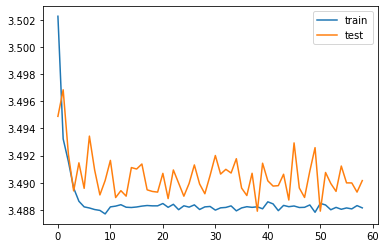

Σταμάτησε μετά από 48 εποχές.


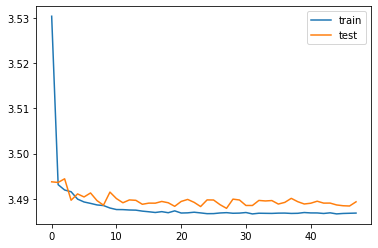

Σταμάτησε μετά από 37 εποχές.


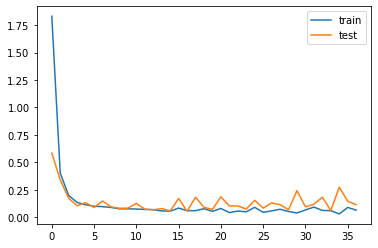

Σταμάτησε μετά από 50 εποχές.


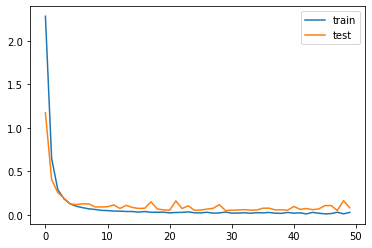

Σταμάτησε μετά από 94 εποχές.


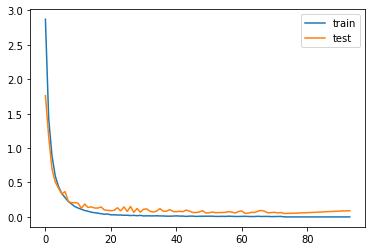

In [ ]:
from matplotlib import pyplot

for i in hs3:
  print('Σταμάτησε μετά από '+ str(len(i.history['loss']))+' εποχές.')
  pyplot.plot(i.history['loss'], label='train')
  pyplot.plot(i.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

In [ ]:
#τέλος διαβάζουμε το csv που έχει τις πραγματικές κατηγορίες των εικόνων του test set
from sklearn.metrics import accuracy_score
import pandas as pd


y_test = pd.read_csv(path+'Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

In [ ]:
#ακολουθούμε την ίδια διαδικασία με το training set για την προεπεξεργασία
data1=[]

for img in imgs:
  img_path = os.path.join(path+img)
  image = tf.keras.preprocessing.image.load_img(img_path,target_size=(30,30),color_mode='rgb')
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  X_test = data1.append(np.array(input_arr))

In [ ]:
X_test=np.array(data1)
X_test = X_test.astype('float32') / 255.0

#και κάνουμε την πρόβλεψη με το test set για να δούμε το accuracy των αρχιτεκονικών μας



from sklearn.metrics import accuracy_score
for i in range(5):
  pred = models1[i].predict_classes(X_test)
  print('Accuracy',accuracy_score(labels, pred)*100)

for i in range(5):
  pred = models2[i].predict_classes(X_test)
  print('Accuracy',accuracy_score(labels, pred)*100)

for i in range(5):
  pred = models3[i].predict_classes(X_test)
  print('Accuracy',accuracy_score(labels, pred)*100)




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy 71.98733174980207
Accuracy 91.39350752177356
Accuracy 93.15122723673792
Accuracy 90.16627078384798
Accuracy 88.54315122723673
Accuracy 5.938242280285035
Accuracy 83.31749802058592
Accuracy 91.353919239905
Accuracy 91.87648456057008
Accuracy 87.07046714172606
Accuracy 5.463182897862233
Accuracy 5.7007125890736345
Accuracy 93.99841646872525
Accuracy 94.63974663499603
Accuracy 94.06967537608868


In [41]:
from tensorflow import keras
import tensorflow 
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Input(shape=X_train[0].shape))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 15, 32)        4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 64)         

In [42]:
#το καλύτερο μοντέλο βγήκε το τελευταίο με learning rate : 0.001 θα κάνουμε επαύξηση δεδομένων
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True
    )
batch_size = 32
epochs = 150

#εκπαιδεύουμε το μοντέλο με 32 batch_size και 12 εποχές ,χρησιμοποιούμε σαν μετρική το accuracy και το test το βάζουμε για validation
l=0.0005
batch_size = 32
epochs = 150
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
adam=tf.keras.optimizers.Adam(learning_rate=l)
model.compile(loss="categorical_crossentropy", optimizer=adam,metrics=["accuracy"])
h4 = model.fit(aug.flow(X_train,y_train,batch_size=batch_size),epochs=epochs, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/150
981/981 [==============================] - 20s 20ms/step - loss: 2.8855 - accuracy: 0.1628 - val_loss: 2.0231 - val_accuracy: 0.3156
Epoch 2/150
981/981 [==============================] - 20s 21ms/step - loss: 1.7932 - accuracy: 0.3879 - val_loss: 1.3987 - val_accuracy: 0.4941
Epoch 3/150
981/981 [==============================] - 20s 20ms/step - loss: 1.1968 - accuracy: 0.5792 - val_loss: 0.7764 - val_accuracy: 0.7224
Epoch 4/150
981/981 [==============================] - 18s 19ms/step - loss: 0.7924 - accuracy: 0.7205 - val_loss: 0.6155 - val_accuracy: 0.7827
Epoch 5/150
981/981 [==============================] - 18s 19ms/step - loss: 0.5662 - accuracy: 0.8010 - val_loss: 0.4733 - val_accuracy: 0.8309
Epoch 6/150
981/981 [==============================] - 18s 19ms/step - loss: 0.4373 - accuracy: 0.8501 - val_loss: 0.2853 - val_accuracy: 0.9008
Epoch 7/150
981/981 [==============================] - 18s 19ms/step - loss: 0.3536 - accuracy: 0.8821 - val_loss: 0.2521 - val_ac

Σταμάτησε μετά από 87 εποχές.


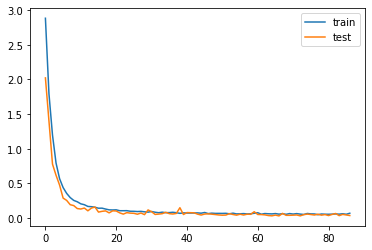

In [43]:
from matplotlib import pyplot

print('Σταμάτησε μετά από '+ str(len(h4.history['loss']))+' εποχές.')
pyplot.plot(h4.history['loss'], label='train')
pyplot.plot(h4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [44]:
#τέλος διαβάζουμε το csv που έχει τις πραγματικές κατηγορίες των εικόνων του test set
from sklearn.metrics import accuracy_score
import pandas as pd


y_test = pd.read_csv(path+'Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

In [45]:
#ακολουθούμε την ίδια διαδικασία με το training set για την προεπεξεργασία
data1=[]

for img in imgs:
  img_path = os.path.join(path+img)
  image = tf.keras.preprocessing.image.load_img(img_path,target_size=(30,30),color_mode='rgb')
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  X_test = data1.append(np.array(input_arr))

In [46]:
X_test=np.array(data1)
X_test = X_test.astype('float32') / 255.0

#και κάνουμε την πρόβλεψη με το test set για να δούμε το accuracy του μοντέλου μας που βγαίνει 91,9%

pred = model.predict_classes(X_test)

from sklearn.metrics import accuracy_score
print('Test Data Accuracy Score',accuracy_score(labels, pred)*100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Data Accuracy Score 96.0332541567696


In [47]:
#δοκιμή σε πραγματικά data
!cp '/content/gdrive/MyDrive/ergasia_tn/fwto.zip' . 
!unzip -q fwto.zip
!rm fwto.zip

replace fwto.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [48]:
y_test = pd.read_csv(path+'fwto.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

In [49]:
print(imgs)

['fwto/2.jpg' 'fwto/4.jpg' 'fwto/7.jpg' 'fwto/11.jpg' 'fwto/12.jpg'
 'fwto/14.png' 'fwto/14_1.png' 'fwto/14_3.jpg' 'fwto/17.jpg' 'fwto/18.jpg'
 'fwto/28.jpg' 'fwto/31.jpg' 'fwto/33.jpg' 'fwto/39.jpg']


In [50]:
data2=[]

for img in imgs:
  img_path = os.path.join(path+img)
  image = tf.keras.preprocessing.image.load_img(img_path,target_size=(30,30),color_mode='rgb')
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  X_test = data2.append(np.array(input_arr))

In [51]:
print(data2)

[array([[[ 91.,  91.,  63.],
        [103.,  95.,  76.],
        [106.,  97.,  82.],
        ...,
        [ 64.,  67.,  58.],
        [ 68.,  68.,  56.],
        [ 55.,  56.,  40.]],

       [[104., 104.,  80.],
        [ 95.,  83.,  69.],
        [108.,  98.,  88.],
        ...,
        [ 62.,  63.,  49.],
        [ 63.,  61.,  46.],
        [ 52.,  48.,  36.]],

       [[105., 100.,  81.],
        [ 92.,  79.,  70.],
        [ 89.,  79.,  70.],
        ...,
        [ 83.,  77.,  61.],
        [ 70.,  63.,  44.],
        [ 68.,  63.,  43.]],

       ...,

       [[ 70.,  72.,  59.],
        [113.,  96.,  80.],
        [ 77.,  57.,  46.],
        ...,
        [ 35.,  45.,  20.],
        [ 71.,  81.,  54.],
        [ 47.,  45.,  33.]],

       [[ 56.,  52.,  40.],
        [ 41.,  34.,  16.],
        [119., 117., 104.],
        ...,
        [116., 108.,  95.],
        [ 69.,  83.,  60.],
        [ 66.,  67.,  51.]],

       [[123., 124., 110.],
        [ 34.,  34.,  26.],
        [  6., 

In [52]:
X_test=np.array(data2)
X_test = X_test.astype('float32') / 255.0

#και κάνουμε την πρόβλεψη με το test set για να δούμε το accuracy του μοντέλου μας που βγαίνει 91,9%

pred = model.predict_classes(X_test)

from sklearn.metrics import accuracy_score
print('Test Data Accuracy Score',accuracy_score(labels, pred)*100)

Test Data Accuracy Score 92.85714285714286


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


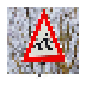

In [53]:
#δοκιμή για plotting μιας εικόνας
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(1, 1))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
plt.imshow(X_test[10], interpolation="none")

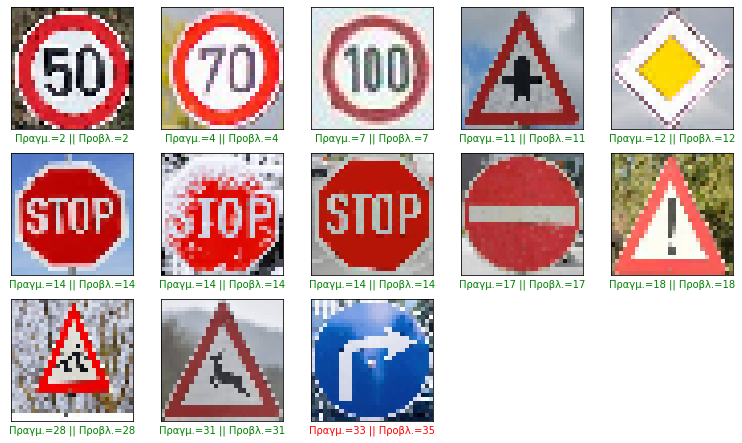

In [54]:
#τέλος βγάζουμε ένα δείγμα 25 εικόνων και βλέπουμε τις πραγματικές με τις προβλεπόμενες τιμές -έτυχε να είναι όλες σωστές

import random
plt.figure(figsize = (13, 13))

start_index = 0
for j in range(13):
    plt.subplot(5, 5, j + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + j]
    actual = labels[start_index + j]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Πραγμ.={} || Προβλ.={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + j])
plt.show()